ЗАДАНИЕ

1. Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика.
2. Определить, с каких источников и в какое время суток чаще всего заходят роботы.

In [64]:
# Произведем запрос метрик
params = {'metrics': 'ym:s:visits,ym:s:robotPercentage',
          'dimensions': 'ym:s:lastsignTrafficSource,ym:s:time',
          'date1': '2020-09-01',
          'date2': '2020-09-30',
          'ids': 30177909,
          'limit': 100000,
          'accuracy':'full'}
token = 'AQAAAABCOahSAAeK-xTF99QRQkg0jIfZW8lKQpo' 
headers = {'Authorization': 'OAuth ' + token}
import json 
import requests
from pprint import pprint
response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)
print (response.status_code)
metrika_data = response.json()
metrika_data['total_rows']


import pandas as pd # Импортируем библиотеку pandas под псевдонимом pd
def getMetrikaDataInListOfDicts(metrika_data):# преобразуем запрос в Датафрайм
    list_of_dicts = []
    dimensions_list = metrika_data['query']['dimensions']
    metrics_list = metrika_data['query']['metrics']
    for data_item in metrika_data['data']:
        d = {}
        for i,dimension in enumerate(data_item['dimensions']):
            d[dimensions_list[i]] = dimension['name']
        for i,metric in enumerate(data_item['metrics']):
            d[metrics_list[i]] = metric
        list_of_dicts.append(d)
    return list_of_dicts
metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrika_data)
metrika_df = pd.DataFrame(metrika_list_of_dicts)

metrika_df.columns=['Source','time','Visits','Percentage%'] #переименуем столбцы
metrika_df['robot'] = metrika_df['Visits']*metrika_df['Percentage%']/100 # высчитаем кол-во ботов заходивших в каждый период времени от общего трафика
display(metrika_df.head(10))

metrika_df1=metrika_df[metrika_df['robot'] != 0] # создадим копии датафраймов для дальнейшей работы
metrika_df2=metrika_df[metrika_df['robot'] != 0]

200


,Source,time,Visits,Percentage%,robot
0,Direct traffic,10:11:50,2.0,100.0,2.0
1,Direct traffic,16:04:40,2.0,50.0,1.0
2,Direct traffic,21:47:08,2.0,50.0,1.0
3,Direct traffic,23:40:13,2.0,50.0,1.0
4,Search engine traffic,00:20:25,2.0,0.0,0.0
5,Search engine traffic,00:31:13,2.0,50.0,1.0
6,Search engine traffic,01:10:16,2.0,0.0,0.0
7,Search engine traffic,08:45:58,2.0,0.0,0.0
8,Search engine traffic,08:59:11,2.0,0.0,0.0
9,Search engine traffic,08:59:16,2.0,50.0,1.0


In [65]:
#Оценим данные получившиеся в датафрайме
metrika_df.info()
#Делаем выводы, что: 
# -пропусков в данных нет 
# -требунется преобразовать тип столбца  time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4236 entries, 0 to 4235
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Source       4236 non-null   object 
 1   time         4236 non-null   object 
 2   Visits       4236 non-null   float64
 3   Percentage%  4236 non-null   float64
 4   robot        4236 non-null   float64
dtypes: float64(3), object(2)
memory usage: 165.6+ KB


1. Оценим количество ботов, которые заходят на наш сайт, и их долю от всего трафика.

In [66]:
print('Количество ботов заходивших на сайт за отчетный период : {}'.format(metrika_df1.robot.sum()))
print ('Доля ботов от всего трафика : {:.2%}'.format(metrika_df1.robot.sum() / metrika_df.Visits.sum()))

Количество ботов заходивших на сайт за отчетный период : 962.0
Доля ботов от всего трафика : 22.29%


Доля ботов от всего трафика приближается к критическим значениям, а именно к допустимому порогу 25%. 
Необходимо искать пути для ограничения подобного трафика на сайте.

2. Определим, с каких источников и в какое время суток чаще всего заходят роботы.

In [67]:
#Определим количество ботов по источникам поступления
metrika_df1=  metrika_df1.groupby(
    ['Source'], 
    as_index=False
)['robot'].sum()
metrika_df1.sort_values(by='robot',ascending=False)

,Source,robot
4,Search engine traffic,739.0
1,Direct traffic,177.0
3,Link traffic,31.0
5,Social network traffic,11.0
2,Internal traffic,3.0
0,Cached page traffic,1.0


In [68]:
print ('Доля ботов от источника Search engine traffic: {:.2%}'.format(739/962))

Доля ботов от источника Search engine traffic: 76.82%


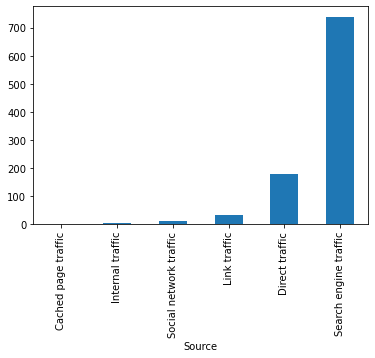

In [69]:
grouped = metrika_df1.groupby(['Source'])['robot'].last().nsmallest(9).plot(kind='bar')

Как можно заметить у нас имеется 6 источников поступления ботов.
Из них наибольший прирост дает источник Search engine traffic (739 заходов за отчетный период, что составляет 76.82% от всего трафика ботов)

In [70]:
#Произведем преобразование типов столбце time
metrika_df2["time"] = pd.to_datetime(metrika_df2['time'], format='%H:%M:%S').dt.hour
metrika_df3 = metrika_df2
metrika_df2=  metrika_df2.groupby(
    ['time'], 
    as_index=False
)['robot'].sum()
import plotly
import plotly.express as px
print(plotly.__version__)# покажем динамику посещения сайта ботами по часам
metrika_df2 = px.line(
    data_frame=metrika_df2, #DataFrame
    x='time', #ось абсцисс
    y='robot', #ось ординат
    height=500, #высота
    width=1000, #ширина
    title='Динамика посещения ботами сайта' #заголовок
)
metrika_df2.show()

5.4.0


<ipython-input-70-3e8012c8503c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
def hour_time(x):
    if 0 <= x <= 5:
        return 'ночь'
    elif 6 <= x <= 11:
        return 'утро'
    elif 12 <= x <= 17:
        return 'день'
    elif 18 <= x <= 23:
        return 'вечер'
metrika_df3['hour'] = metrika_df3.time.apply(hour_time)
metrika_df3.value_counts(['hour'], ascending=False)


<ipython-input-71-7012feabab7b>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



hour 
день     439
вечер    237
утро     226
ночь      55
dtype: int64

In [72]:
print ('Доля ботов в дневной период: {:.2%}'.format(439/962))

Доля ботов в дневной период: 45.63%


Как видно по графику наибольший процент посещения сайта ботами приходится на день в период с 11 до 16 часов, 
что составляет 45,63% от всего трафика ботов за отчетный период.